<a href="https://colab.research.google.com/github/Choudharynipun/Real-Time-Food-Detection/blob/main/Real_TIme_Food_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Downloading Training Dataset
!wget -q https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/train-v0.4.tar.gz -O train.zip

# Downloading Validation Dataset
!wget -q https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/val-v0.4.tar.gz -O val.zip

In [ ]:
# Unzipping Training Dataset
!unzip train.zip > /dev/null

  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train.zip or
        train.zip.zip, and cannot find train.zip.ZIP, period.


In [ ]:
# Unzipping Validation Dataset
!unzip val.zip > /dev/null

  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of val.zip or
        val.zip.zip, and cannot find val.zip.ZIP, period.


So, the data structure is something like this

```
content
|
└─── sample_data
|
└─── Train 
│   │   annotations.json
│   └───images
│       │   012170.jpg
│       │   012030.jpg
│       │   ...
│   
└─── val
│   │   annotations.json
│   └───images
│       │   011397.jpg
│       │   012340.jpg
│       │   ...
|    train.zip
|    val.zip
```

## Importing Necessary Libraries

In [ ]:
# Making sure that we are using GPUs
!nvidia-smi 

Mon May 15 18:45:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.5 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=69339614a0a59e828d2fbb7a4058a67d5b78ee567ec0fa597212b7a437599f5e
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Succe

In [ ]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
ERROR: Could not find a version that satisfies the requirement detectron2==0.1.2 (from versions: none)
ERROR: No matching distribution found for detectron2==0.1.2


In [ ]:


# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# For reading annotations file
from pycocotools.coco import COCO

# utilities
from pprint import pprint # For beautiful print!
import os 

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from google.colab.patches import cv2_imshow

ModuleNotFoundError: ignored

## Reading Data

In [ ]:
# Reading annotations.json

TRAIN_ANNOTATIONS_PATH = "/content/drive/MyDrive/aicrowd/annotations/training.json"
TRAIN_IMAGE_DIRECTIORY = "/content/train/images/"

VAL_IMAGE_DIRECTIORY = "/content/drive/MyDrive/aicrowd/annotations/validation.json"
VAL_ANNOTATIONS_PATH = "/content/val/annotations.json"

train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=4.92s)
creating index...
index created!


In [ ]:
# Reading the annotation files
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
  val_annotations_data = json.load(f)

FileNotFoundError: ignored

In [ ]:

train_annotations_data['annotations'][0]

Data Format:

Our COCO data format is something like this -

```
"info": {...},
"categories": [...],
"images": [...],
"annotations": [...],
```

In which categories is like this
```
[
  {'id': 2578,
  'name': 'water',
  'name_readable': 'Water',
  'supercategory': 'food'},
  {'id': 1157,
  'name': 'pear',
  'name_readable': 'Pear',
  'supercategory': 'food'},
  ...
  {'id': 1190,
  'name': 'peach',
  'name_readable': 'Peach',
  'supercategory': 'food'}
]
```

Info is empty ( not sure why )

images is like this

```
[
  {'file_name': '065537.jpg', 
  'height': 464, 
  'id': 65537, 
  'width': 464},
  {'file_name': '065539.jpg', 
  'height': 464, 
  'id': 65539, 
  'width': 464},
 ...
  {'file_name': '069900.jpg', 
  'height': 391, 
  'id': 69900, 
  'width': 392},
]
```
Annotations is like this

```
{'area': 44320.0,
 'bbox': [86.5, 127.49999999999999, 286.0, 170.0],
 'category_id': 2578,
 'id': 102434,
 'image_id': 65537,
 'iscrowd': 0,
 'segmentation': [[235.99999999999997,
   372.5,
   169.0,
   372.5,
   ...
   368.5,
   264.0,
   371.5]]}
```


In [ ]:
# Reading all classes

category_ids = train_coco.loadCats(train_coco.getCatIds())

category_names = [_["name_readable"] for _ in category_ids]

pprint(", ".join(category_names))

('Water, Pear, Egg, Grapes, Butter, Bread, white, Jam, Bread, whole wheat, '
 'Apple, Tea, green, White coffee, with caffeine, Tea, black, Mixed salad '
 '(chopped without sauce), Cheese, Tomato sauce, Pasta, spaghetti, Carrot, '
 'Onion, Beef, cut into stripes (only meat), Rice noodles/vermicelli, Salad, '
 'leaf / salad, green, Bread, grain, Espresso, with caffeine, Banana, Mixed '
 'vegetables, Bread, wholemeal, Savoury puff pastry, Wine, white, Dried meat, '
 'Fresh cheese, Red radish, Hard cheese, Ham, raw, Bread, fruit, Oil & vinegar '
 'salad dressing, Tomato, Cauliflower, Potato-gnocchi, Wine, red, Sauce, '
 'cream, Pasta, linguini, parpadelle, Tagliatelle, French beans, Almonds, Dark '
 'chocolate, Mandarine, Semi-hard cheese, Croissant, Sushi, Berries, Biscuits, '
 'Thickened cream (> 35%), Corn, Celeriac, Alfa sprouts, Chickpeas, Leaf '
 'spinach, Rice, Chocolate cookies, Pineapple, Tart, Coffee, with caffeine, '
 'Focaccia, Pizza, with vegetables, baked, Soup, vegetable, Br

In [ ]:
category_names

['Water',
 'Pear',
 'Egg',
 'Grapes',
 'Butter',
 'Bread, white',
 'Jam',
 'Bread, whole wheat',
 'Apple',
 'Tea, green',
 'White coffee, with caffeine',
 'Tea, black',
 'Mixed salad (chopped without sauce)',
 'Cheese',
 'Tomato sauce',
 'Pasta, spaghetti',
 'Carrot',
 'Onion',
 'Beef, cut into stripes (only meat)',
 'Rice noodles/vermicelli',
 'Salad, leaf / salad, green',
 'Bread, grain',
 'Espresso, with caffeine',
 'Banana',
 'Mixed vegetables',
 'Bread, wholemeal',
 'Savoury puff pastry',
 'Wine, white',
 'Dried meat',
 'Fresh cheese',
 'Red radish',
 'Hard cheese',
 'Ham, raw',
 'Bread, fruit',
 'Oil & vinegar salad dressing',
 'Tomato',
 'Cauliflower',
 'Potato-gnocchi',
 'Wine, red',
 'Sauce, cream',
 'Pasta, linguini, parpadelle, Tagliatelle',
 'French beans',
 'Almonds',
 'Dark chocolate',
 'Mandarine',
 'Semi-hard cheese',
 'Croissant',
 'Sushi',
 'Berries',
 'Biscuits',
 'Thickened cream (> 35%)',
 'Corn',
 'Celeriac',
 'Alfa sprouts',
 'Chickpeas',
 'Leaf spinach',
 'Rice'

In [ ]:
# Getting all categoriy with respective to their total images

no_images_per_category = {}

for n, i in enumerate(train_coco.getCatIds()):
  imgIds = train_coco.getImgIds(catIds=i)
  label = category_names[n]
  no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))

no_images_per_category

{'Alfa sprouts': 40,
 'Almonds': 159,
 'Apple': 504,
 'Apple pie': 104,
 'Applesauce, unsweetened, canned': 39,
 'Apricots': 91,
 'Artichoke': 43,
 'Avocado': 296,
 'Bacon, cooking': 47,
 'Bacon, frying': 127,
 'Balsamic salad dressing': 117,
 'Banana': 412,
 'Beans, kidney': 40,
 'Beef': 85,
 'Beef, cut into stripes (only meat)': 41,
 'Beef, filet': 51,
 'Beef, minced (only meat)': 65,
 'Beef, sirloin steak': 41,
 'Beer': 158,
 'Beetroot, raw': 45,
 'Beetroot, steamed, without addition of salt': 91,
 'Berries': 64,
 'BirchermÃ¼esli, prepared, no sugar added': 96,
 'Biscuits': 134,
 'Black olives': 132,
 'Blue mould cheese': 68,
 'Blueberries': 159,
 'Boisson au glucose 50g': 171,
 'Bolognaise sauce': 87,
 'Braided white loaf': 194,
 'Bread': 63,
 'Bread, 5-grain': 48,
 'Bread, French (white flour)': 121,
 'Bread, black': 54,
 'Bread, fruit': 48,
 'Bread, grain': 102,
 'Bread, half white': 76,
 'Bread, nut': 57,
 'Bread, pita': 38,
 'Bread, rye': 47,
 'Bread, sourdough': 124,
 'Bread, 

In [ ]:
pd.DataFrame(no_images_per_category.items()).sort_values(1).iloc[::-1][0][:30].tolist()

['Water',
 'Bread, white',
 'Salad, leaf / salad, green',
 'Tomato',
 'Butter',
 'Bread, wholemeal',
 'Carrot',
 'Coffee, with caffeine',
 'Rice',
 'Egg',
 'Mixed vegetables',
 'Wine, red',
 'Apple',
 'Jam',
 'Potatoes steamed',
 'Banana',
 'Cheese',
 'Espresso, with caffeine',
 'Cucumber',
 'Mixed salad (chopped without sauce)',
 'Tea',
 'Wine, white',
 'Hard cheese',
 'Avocado',
 'Tomato sauce',
 'Chicken',
 'Sweet pepper',
 'White coffee, with caffeine',
 'Broccoli',
 'Pasta, spaghetti']

## Data Visualisations

In [ ]:
fig = go.Figure([go.Bar(x=list(no_images_per_category.keys()), y=list(no_images_per_category.values()))])
fig.update_layout(
    title="No of Image per class",)
fig.show()

In [ ]:
pprint(f"Average number of image per class : { sum(list(no_images_per_category.values())) / len(list(no_images_per_category.values())) }")
pprint(f"Highest number of image per class is : { list(no_images_per_category.keys())[0]} of { list(no_images_per_category.values())[0] }")
pprint(f"Lowest number of image per class is : Veggie Burger of { sorted(list(no_images_per_category.values()))[0] }")

'Average number of image per class : 143.6153846153846'
'Highest number of image per class is : Water of 1835'
'Lowest number of image per class is : Veggie Burger of 35'


In [ ]:
fig = go.Figure(data=[go.Pie(labels=list(no_images_per_category.keys()), values=list(no_images_per_category.values()), 
                             hole=.3, textposition='inside', )], )
fig.update_layout(
    title="No of Image per class ( In pie )",)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=img_info['height']))
fig.add_trace(go.Histogram(x=img_info['width']))

# Overlay both histograms
fig.update_layout(barmode='stack', title="Histogram of Image width & height",)


fig.show()

# Image Visulisation 🖼️

In this section  we are going to do imaghe visualisations!

In [ ]:
img_info

id   file_name  width  height
0      65537  065537.jpg    464     464
1      65539  065539.jpg    464     464
2      65561  065561.jpg    464     464
3      65574  065574.jpg    831     830
4      65577  065577.jpg    480     480
...      ...         ...    ...     ...
24115  65500  065500.jpg    628     628
24116  65514  065514.jpg   1037    1036
24117  65516  065516.jpg    480     480
24118  65523  065523.jpg    480     480
24119  65524  065524.jpg    464     464

[24120 rows x 4 columns]

In [ ]:
len(train_annotations_data['annotations'][n]['segmentation']), len(train_annotations_data['annotations'][n]['bbox'])

(2, 4)

In [ ]:
for n, i in enumerate(tqdm((train_annotations_data['annotations']))):

  # if np.array(train_annotations_data['annotations'][n]['segmentation']).shape[0] != np.array(train_annotations_data['annotations'][n]['bbox']).shape[0]:

    # print(n)
  if np.array(train_annotations_data['annotations'][n]['segmentation']).shape[0] != 1:
    print(n)

  else:
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



20
33
49
65
66
68
77
99
108
125
135
136
184
190
192
194
195
196
210
222
230
231
248
256
264
272
284
300
312
315
316
318
323
343
352
357
360
379
382
385
405
429
432
457
462
464
480
481
491
492
493
498
502
503
505
506
516
522
523
528
538
540
541
545
567
583
585
586
594
595
596
598
615
627
632
665
669
686
687
691
712
719
722
733
738
744
745
748
753
760
784
785
787
789
795
801
804
805
806
809
829
830
833
843
846
851
852
876
885
887
909
926
932
933
950
952
954
969
970
977
979
982
989
993
998
1000
1031
1034
1035
1045
1049
1054
1055
1061
1065
1068
1070
1073
1089
1099
1108
1110
1118
1120
1133
1134
1146
1149
1154
1176
1177
1185
1187
1188
1198
1204
1207
1214
1215
1217
1218
1246
1258
1259
1276
1277
1286
1287
1289
1300
1301
1307
1309
1335
1341
1343
1345
1361
1362
1370
1377
1380
1399
1412
1441
1443
1445
1486
1501
1537
1539
1582
1584
1599
1608
1625
1628
1658
1660
1662
1663
1667
1668
1691
1699
1708
1716
1720
1721
1735
1740
1743
1760
1772
1785
1815
1820
1826
1830
1834
1838
1876
1880
1886
1895
1896
190

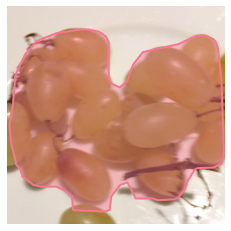

In [ ]:

img_no = 4

annIds = train_coco.getAnnIds(imgIds=train_annotations_data['annotations'][img_no]['image_id'])
anns = train_coco.loadAnns(annIds)

# load and render the image

plt.imshow(plt.imread(TRAIN_IMAGE_DIRECTIORY+train_annotations_data['images'][img_no]['file_name']))
plt.axis('off')
# Render annotations on top of the image
train_coco.showAnns(anns)


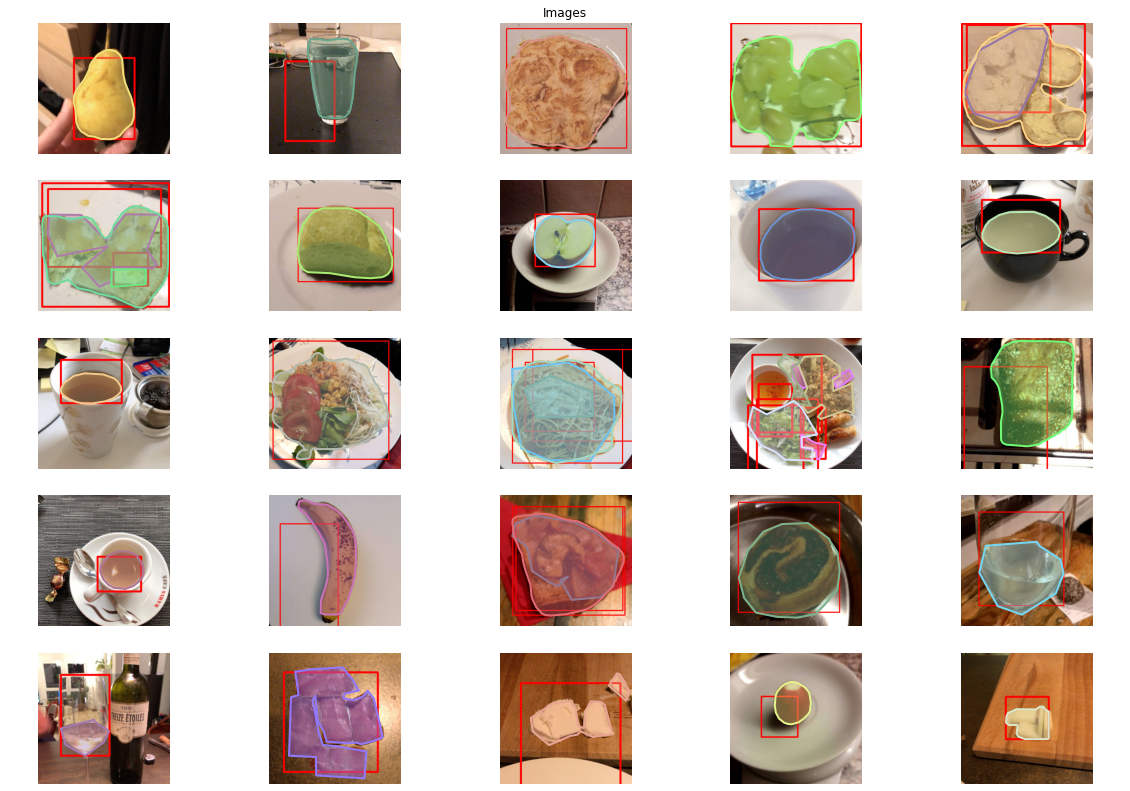

In [ ]:
w, h = 12, 12 # Setting width and height of every image
rows, cols = 5, 5 # Setting the number of image rows & cols

fig = plt.figure(figsize=(20, 14)) # Making the figure with size 

plt.title("Images") 
plt.axis('off')

# Going thought every cell in rows and cols
for i in range(1, cols * rows+1):

  annIds = train_coco.getAnnIds(imgIds=img_info['id'][i])
  anns = train_coco.loadAnns(annIds)

  fig.add_subplot(rows, cols, i)

  # Show the image

  img = plt.imread(TRAIN_IMAGE_DIRECTIORY+img_info['file_name'][i])

  for i in anns:
    [x,y,w,h] = i['bbox']
    cv2.rectangle(img, (int(x), int(y)), (int(x+h), int(y+w)), (255,0,0), 5)

  plt.imshow(img)

  # Render annotations on top of the image
  train_coco.showAnns(anns)


  # Setting the axis off
  plt.axis("off")

# Showing the figure
plt.show()

## Fixing the Data

In [ ]:
np.array(train_annotations_data['annotations'][n]['segmentation']).shape , np.array(train_annotations_data['annotations'][n]['bbox']).shape

((1, 22), (4,))

In [ ]:
# Function for taking a annotation & directiory of images and returning new annoation json with fixed image size info
def fix_data(annotations, directiory):
  for n, i in enumerate(tqdm((annotations['images']))):
   
      img = cv2.imread(directiory+i["file_name"])
 

      if img.shape[0] != i['height']:
          annotations['images'][n]['height'] = img.shape[0]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

  return annotations

    
train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTIORY)

  
with open('/content/train/new_ann.json', 'w') as f:
    json.dump(train_annotations_data, f)


In [ ]:
def fix_data_val(annotations, directiory):
  for n, i in enumerate(tqdm((annotations['images']))):
   
      img = cv2.imread(directiory+i["file_name"])
      
 

      if img.shape[0] != i['height']:
          print(n)
          annotations['images'][n]['height'] = img.shape[0]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

  return annotations

val_annotations_data = fix_data_val(val_annotations_data, VAL_IMAGE_DIRECTIORY)

with open('/content/val/new_ann.json', 'w') as f:
    json.dump(val_annotations_data, f)

AttributeError: ignored

In [ ]:
dict_addres = val_annotations_data['images'][748]
plt.imread(VAL_IMAGE_DIRECTIORY+dict_addres['file_name']).shape[:2], (dict_addres['height'], dict_addres['width'])

((3456, 4608), (4608, 3456))

In [ ]:
for n, i in enumerate(val_annotations_data['images']):
  if i['file_name'] == '053879.jpg':
    print(n)
    print("yes") 

748
yes


## Creating our Dataset

In [ ]:
train_annotations_path = '/content/train/new_ann.json'
train_images_path = '/content/train/images'

val_annotations_path = '/content/val/new_ann.json'
val_images_path = '/content/val/images'

In [ ]:
register_coco_instances("training_dataset", {},train_annotations_path, train_images_path)

register_coco_instances("validation_dataset", {},val_annotations_path, VAL_IMAGE_DIRECTIORY)

## Creating R-CNN Model

In [ ]:
cfg = get_cfg()
# Check the model zoo and use any of the models ( from detectron2 github repo)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("training_dataset",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
# Loading pre trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

## Setting up hyperparameters

In [ ]:
# No. of Batchs
cfg.SOLVER.IMS_PER_BATCH = 2

# Learning Rate: 
cfg.SOLVER.BASE_LR = 0.00025 

# No of Interations
cfg.SOLVER.MAX_ITER = 2000

# Images per batch (Batch Size) 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   

# No of Categories(Classes) present
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 273

cfg.OUTPUT_DIR = "/content/logs/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/08 07:20:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 94.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (274, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (274,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (1092, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (1092,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the mode

In [ ]:
!pip install --upgrade git+git://github.com/wandb/client.git

  Cloning git://github.com/wandb/client.git to /tmp/pip-req-build-coaxvwht
  Running command git clone -q git://github.com/wandb/client.git /tmp/pip-req-build-coaxvwht
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 12.2MB/s 
     |████████████████████████████████| 122kB 30.3MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for wandb: filename=wandb-0.10.7.dev1-cp36-none-any.whl size=1693091 sha256=3222c8a75719b9aa12ceb6adced4c065c1111c0d8098a7cc6230f65173b46b03
  Stored in directory: /tmp/pip-ephem-wheel-cache-s8m9f4gs/wheels/f5/bb/45/4b2ff6f79b35baf639a4eaf2673c5df97fa21335bf82cc7bfa
Successfully built wandb
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=797ae5ded101c517d2dd89c

In [ ]:
trainer.train()

[11/08 07:20:34 d2.engine.train_loop]: Starting training from iteration 0
[11/08 07:20:41 d2.utils.events]:  eta: 0:10:28  iter: 19  total_loss: 6.803  loss_cls: 5.567  loss_box_reg: 0.527  loss_mask: 0.692  loss_rpn_cls: 0.026  loss_rpn_loc: 0.016  time: 0.3200  data_time: 0.0174  lr: 0.000005  max_mem: 1926M
[11/08 07:20:48 d2.utils.events]:  eta: 0:10:25  iter: 39  total_loss: 6.706  loss_cls: 5.464  loss_box_reg: 0.521  loss_mask: 0.693  loss_rpn_cls: 0.008  loss_rpn_loc: 0.012  time: 0.3217  data_time: 0.0074  lr: 0.000010  max_mem: 2090M
[11/08 07:20:54 d2.utils.events]:  eta: 0:10:24  iter: 59  total_loss: 6.288  loss_cls: 4.979  loss_box_reg: 0.626  loss_mask: 0.693  loss_rpn_cls: 0.023  loss_rpn_loc: 0.021  time: 0.3261  data_time: 0.0117  lr: 0.000015  max_mem: 2090M
[11/08 07:21:01 d2.utils.events]:  eta: 0:10:20  iter: 79  total_loss: 5.606  loss_cls: 4.338  loss_box_reg: 0.560  loss_mask: 0.692  loss_rpn_cls: 0.034  loss_rpn_loc: 0.014  time: 0.3271  data_time: 0.0073  lr:

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning:

Metadata Warning, tag 282 had too many entries: 2, expected 1

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning:

Metadata Warning, tag 283 had too many entries: 2, expected 1



[11/08 07:22:46 d2.utils.events]:  eta: 0:09:18  iter: 379  total_loss: 2.436  loss_cls: 1.109  loss_box_reg: 0.648  loss_mask: 0.675  loss_rpn_cls: 0.010  loss_rpn_loc: 0.014  time: 0.3448  data_time: 0.0291  lr: 0.000095  max_mem: 2723M
[11/08 07:22:53 d2.utils.events]:  eta: 0:09:12  iter: 399  total_loss: 2.420  loss_cls: 1.106  loss_box_reg: 0.596  loss_mask: 0.673  loss_rpn_cls: 0.014  loss_rpn_loc: 0.013  time: 0.3452  data_time: 0.0086  lr: 0.000100  max_mem: 2723M
[11/08 07:23:00 d2.utils.events]:  eta: 0:09:05  iter: 419  total_loss: 2.638  loss_cls: 1.189  loss_box_reg: 0.760  loss_mask: 0.674  loss_rpn_cls: 0.005  loss_rpn_loc: 0.011  time: 0.3454  data_time: 0.0075  lr: 0.000105  max_mem: 2723M
[11/08 07:23:07 d2.utils.events]:  eta: 0:09:00  iter: 439  total_loss: 2.604  loss_cls: 1.206  loss_box_reg: 0.669  loss_mask: 0.676  loss_rpn_cls: 0.007  loss_rpn_loc: 0.012  time: 0.3458  data_time: 0.0078  lr: 0.000110  max_mem: 2723M
[11/08 07:23:14 d2.utils.events]:  eta: 0:08

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning:

Metadata Warning, tag 282 had too many entries: 2, expected 1

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning:

Metadata Warning, tag 283 had too many entries: 2, expected 1



[11/08 07:24:49 d2.utils.events]:  eta: 0:07:29  iter: 719  total_loss: 2.147  loss_cls: 0.979  loss_box_reg: 0.628  loss_mask: 0.555  loss_rpn_cls: 0.004  loss_rpn_loc: 0.009  time: 0.3525  data_time: 0.0179  lr: 0.000180  max_mem: 2723M
[11/08 07:24:57 d2.utils.events]:  eta: 0:07:23  iter: 739  total_loss: 2.420  loss_cls: 1.120  loss_box_reg: 0.669  loss_mask: 0.596  loss_rpn_cls: 0.013  loss_rpn_loc: 0.010  time: 0.3534  data_time: 0.0262  lr: 0.000185  max_mem: 2723M
[11/08 07:25:04 d2.utils.events]:  eta: 0:07:16  iter: 759  total_loss: 2.407  loss_cls: 1.078  loss_box_reg: 0.640  loss_mask: 0.604  loss_rpn_cls: 0.009  loss_rpn_loc: 0.010  time: 0.3539  data_time: 0.0150  lr: 0.000190  max_mem: 2723M
[11/08 07:25:12 d2.utils.events]:  eta: 0:07:09  iter: 779  total_loss: 2.255  loss_cls: 0.998  loss_box_reg: 0.616  loss_mask: 0.568  loss_rpn_cls: 0.005  loss_rpn_loc: 0.009  time: 0.3545  data_time: 0.0063  lr: 0.000195  max_mem: 2723M
[11/08 07:25:19 d2.utils.events]:  eta: 0:07

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

evaluator = COCOEvaluator("validation_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "validation_dataset")
valResults = inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [10/17 07:39:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/17 07:39:37 d2.data.datasets.coco]: Loaded 1269 images in COCO format from /content/val/new_ann.json
[10/17 07:39:37 d2.data.common]: Serializing 1269 elements to byte tensors and concatenating them all ...
[10/17 07:39:37 d2.data.common]: Serialized dataset takes 3.59 MiB
[10/17 07:39:37 d2.evaluation.evaluator]: Start inference on 1269 images
[10/17 07:39:38 d2.evaluation.evaluator]: Inference done 11/1269. 0.0565 s / img. ETA=0:01:16
[10/17 07:39:43 d2.evaluation.evaluator]: Inference done 90/1269. 0.0572 s / img. ETA=0:01:15
[10/17 07:39:48 d2.evaluation.evaluator]: Inference done 164/1269. 0.0579 s / img. ETA=0:01:12
[10/17 07:39:53 d2.evaluation.evaluator]: Inference done 237/1269. 0.0580 s / img. ETA=0:01:09
[10/17 07:39:58 d2.evaluation.evaluator]: Inference done 304/1269. 0.0581 s / img. ETA=0:01:06
[10/17 07:40:04 d2.evaluation.evaluato

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning:

Metadata Warning, tag 282 had too many entries: 2, expected 1

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning:

Metadata Warning, tag 283 had too many entries: 2, expected 1

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning:

Metadata Warning, tag 34853 had too many entries: 9, expected 1



[10/17 07:40:21 d2.evaluation.evaluator]: Inference done 579/1269. 0.0584 s / img. ETA=0:00:52
[10/17 07:40:26 d2.evaluation.evaluator]: Inference done 652/1269. 0.0585 s / img. ETA=0:00:46
[10/17 07:40:31 d2.evaluation.evaluator]: Inference done 727/1269. 0.0585 s / img. ETA=0:00:40
[10/17 07:40:36 d2.evaluation.evaluator]: Inference done 802/1269. 0.0585 s / img. ETA=0:00:34
[10/17 07:40:41 d2.evaluation.evaluator]: Inference done 880/1269. 0.0585 s / img. ETA=0:00:28
[10/17 07:40:46 d2.evaluation.evaluator]: Inference done 954/1269. 0.0585 s / img. ETA=0:00:22
[10/17 07:40:51 d2.evaluation.evaluator]: Inference done 1034/1269. 0.0584 s / img. ETA=0:00:16
[10/17 07:40:56 d2.evaluation.evaluator]: Inference done 1107/1269. 0.0585 s / img. ETA=0:00:11
[10/17 07:41:01 d2.evaluation.evaluator]: Inference done 1185/1269. 0.0584 s / img. ETA=0:00:05
[10/17 07:41:06 d2.evaluation.evaluator]: Inference done 1268/1269. 0.0583 s / img. ETA=0:00:00
[10/17 07:41:07 d2.evaluation.evaluator]: Tota

In [ ]:


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 273

cfg.DATASETS.TEST = ("validation_dataset", )
predictor = DefaultPredictor(cfg)

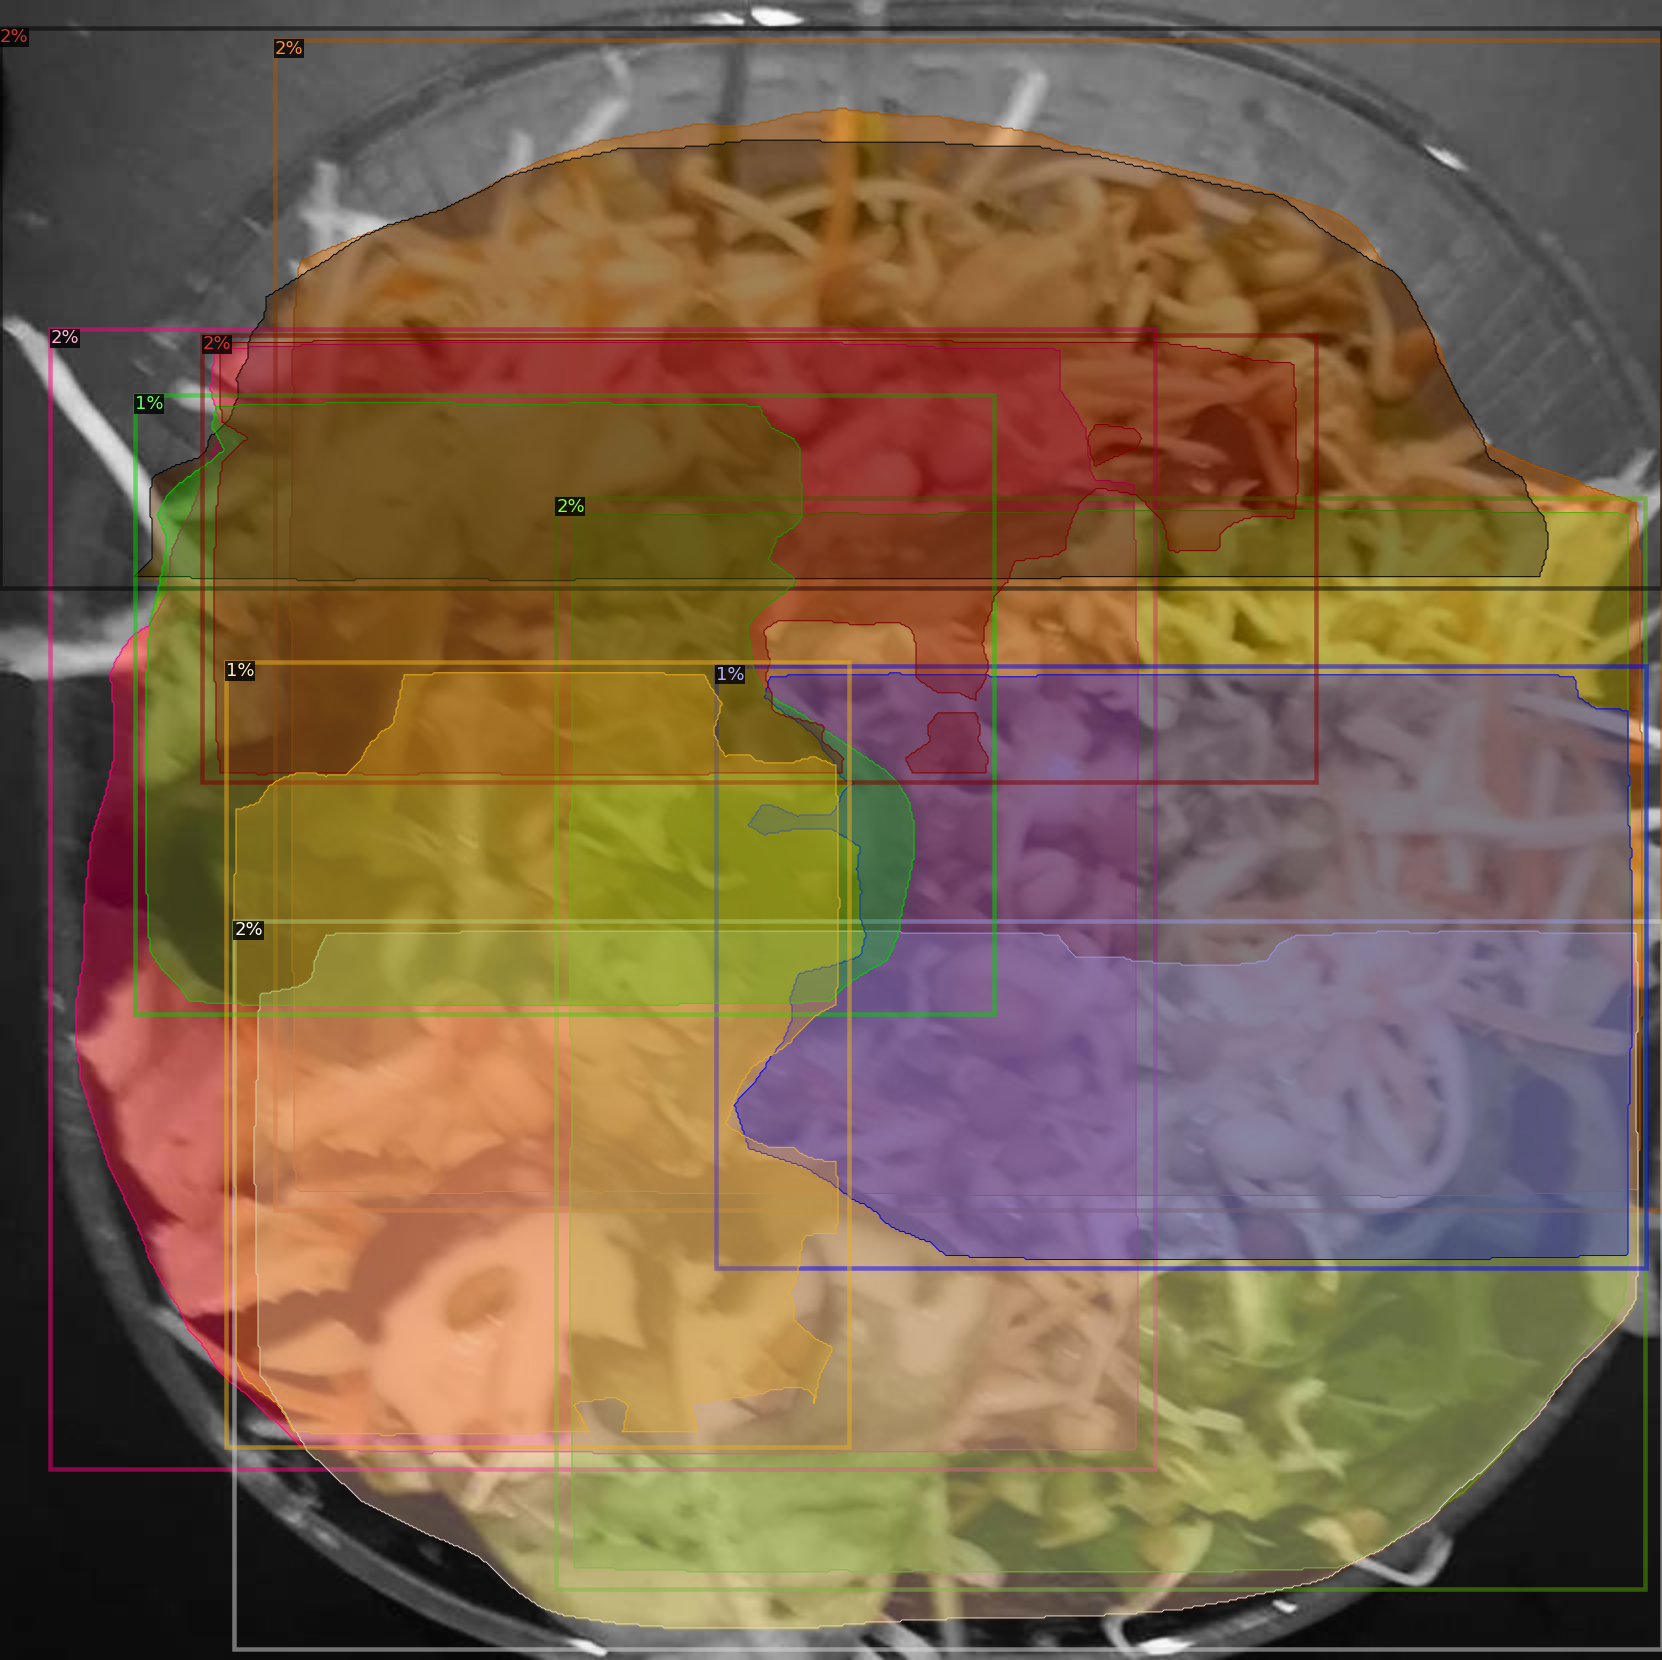

In [ ]:
val_metadata = MetadataCatalog.get("val_dataset")

im = cv2.imread("val/images/084035.jpg")

outputs = predictor(im)

v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=2, 
               

                   instance_mode=ColorMode.IMAGE_BW
    )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
trainer.resume_or_load(resume=True)

In [ ]:
aicrowd_submission = {
    "author": "Shubham",
    "username": "Shubhamai",
    "description": "detectron2 trial 2",
    "model_path": "logs/model_final.pth",
    "model_type": "model_zoo",
    "model_config_file": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    "detectron_model_config": {
      "ROI_HEADS": {
        "SCORE_THRESH_TEST": 0.3,
        "NUM_CLASSES": 273
      }
    }
}

aicrowd_submission["description"] = aicrowd_submission["description"].replace(" ", "-")
with open("aicrowd.json", "w") as fp:
  json.dump(aicrowd_submission, fp)

In [ ]:
from pycocotools.coco import COCO
import json

coco_api = COCO(TRAIN_ANNOTATIONS_PATH)

category_ids = sorted(coco_api.getCatIds())
categories = coco_api.loadCats(category_ids)

class_to_category = { int(class_id): int(category_id) for class_id, category_id in enumerate(category_ids) }

with open("class_to_category.json", "w") as fp:
  json.dump(class_to_category, fp)

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


In [ ]:
!bash <(curl -sL https://gitlab.aicrowd.com/jyotish/food-recognition-challenge-detectron2-baseline/raw/master/utils/submit-colab.sh)

4/6AGMvrF0BpkxiyuEgRUOBTD_5Z02OyP0lpURVjWWWOEYFMIxFdKa3Gg
4/6AGMvrF0BpkxiyuEgRUOBTD_5Z02OyP0lpURVjWWWOEYFMIxFdKa3Gg
4/6AGMvrF0BpkxiyuEgRUOBTD_5Z02OyP0lpURVjWWWOEYFMIxFdKa3Gg
4/6AGMvrF0BpkxiyuEgRUOBTD_5Z02OyP0lpURVjWWWOEYFMIxFdKa3Gg
4/6AGMvrF0BpkxiyuEgRUOBTD_5Z02OyP0lpURVjWWWOEYFMIxFdKa3Gg
Preparing the environment for submission 💪


🔍 Checking for SSH key...
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
Mounted at /content/drive
Verified! ✅

⚙️ Setting up git... 
Identity added: /content/drive/My Drive/aicrowd/id_ecdsa (/content/drive/My Dri

In [ ]:
!pip install --upgrade fastai

     |████████████████████████████████| 194kB 4.5MB/s 
     |████████████████████████████████| 748.8MB 18kB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 5.9MB 49.7MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.vision.core import *
from fastai.vision.utils import *
from fastai.vision.augment import *
from fastai.data.core import *
from fastai.data.transforms import *

In [ ]:
images, lbl_bbox = get_annotations('/content/train/annotations.json')
# idx=2
# coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]

# def _coco_bb(x):  return TensorBBox.create(bbox[0])
# def _coco_lbl(x): return bbox[1]

In [ ]:
idx=4
coco_fn,bbox = '/content/train/images/'+images[idx],lbl_bbox[idx]

def _coco_bb(x):  return TensorBBox.create(bbox[0])
def _coco_lbl(x): return bbox[1]


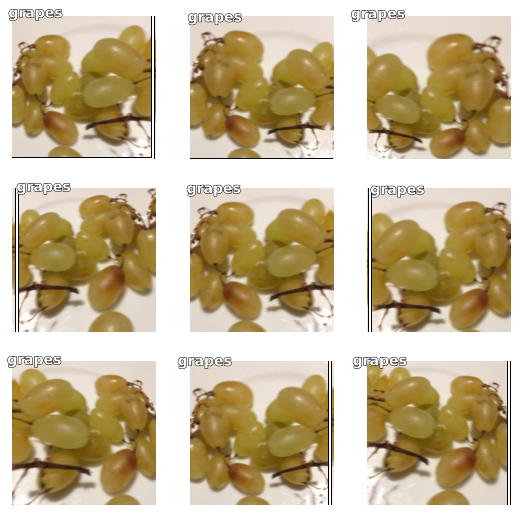

In [ ]:
coco_dsrc = Datasets([coco_fn]*10, [PILImage.create, [_coco_bb,], [_coco_lbl, MultiCategorize(add_na=True)]], n_inp=1)
coco_tdl = TfmdDL(coco_dsrc, bs=9, after_item=[BBoxLabeler(), PointScaler(), ToTensor(), Resize(256)],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

coco_tdl.show_batch(max_n=9)